<a href="https://colab.research.google.com/github/aghosh92/Cation-Ordering-ML/blob/main/RF_classifier_probab_causal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been prepared by Ayana Ghosh.

Email: research.aghosh@gmail.com

It shows the following:

1. How Random Forest Classification models can be trained and tested on a DFT-based dataset followed by visualizing trees and downselecting important features.

2. Probabilistic confidence bound along with interactive plots can be utilized to test accuracies of models.

3. How causal networks can be constructed using the important features to investigate structure-property relationships.

Install packages

In [1]:
!pip install -q plotly
!pip install lingam

     |████████████████████████████████| 58 kB 4.7 MB/s 


Import essential libraries

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
from pandas import json_normalize
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
import json
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import graphviz
import lingam
from lingam.utils import make_prior_knowledge
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read in the Data (.csv files)

In [10]:
!gdown https://drive.google.com/uc?id=1XqxI2bHXbqwl_kfQOIWJn0VTh49KmAAk

Downloading...
From: https://drive.google.com/uc?id=1XqxI2bHXbqwl_kfQOIWJn0VTh49KmAAk
To: /content/Merge_DFT_mode_dataset.csv
100% 92.4k/92.4k [00:00<00:00, 32.8MB/s]


In [11]:
data = pd.read_csv('/content/Merge_DFT_mode_dataset.csv')

In [12]:
#print dataset
data

,Index,Compound name,A site,A'site,B site,B'site,C_A,C_A',Cn_A,Cn_A',C_B,C_B',Cn_B,Cn_B',r_Asite,r_A'site,r_Bsite,r_B'site,Avg_AA',Avg_BB',TF,Energy,Fermi_energy,_cell_length_a,_cell_length_b,_cell_length_c,_cell_angle_alpha,_cell_angle_beta,_cell_angle_gamma,_cell_volume,space_group_LS,Space_group_No_LS,space_group_HS,Space_group_No_HS,Total_mag_Outcar,mag_B,mag_B',mag_O,A_s,A_p,A_d,A'_s,A'_p,A'_d,B_s,B_p,B_d,B'_s,B'_p,B'_d,O_s,O_p,dis_x_A1,dis_x_A2,dis_y_A1,dis_y_A2,dis_x_A'1,dis_x_A'2,dis_y_A'1,dis_y_A'2,|x_A_dis|,|y_A_dis|,|x_A'_dis|,|y_A'_dis|,|A_dis|,|A'_dis|,tilt_angle,rot_angle,Q_R-,Q_R+,Q_T,Q_AFE_(A),Q_AFE_(O),CD_(2D),CD_(3D),target_label
0,Comp_0,BaCeMnNiO6_C,Ba,Ce,Mn,Ni,2,4,8,8,4,2,6,6,1.42,0.97,0.53,0.69,0.750,0.61,0.757729,-143.235200,4.972623,5.518559,5.518564,7.536327,90.198578,90.107948,88.998055,229.478362,P-1,2,P42/mmc,131,9.687,2.7435,1.7130,0.051000,2.009,5.635,0.389,1.9540,5.6170,0.6760,0.3625,0.5825,4.8820,0.3710,0.5030,8.2385,1.563667,3.435167,-0.004051,0.004051,-0.007882,-0.007882,-0.008241,0.008241,-0.017914,0.017914,0.004051,0.007882,0.008241,0.017914,0.008862,0.019719,13.669744,4.602608,0.00487,0.25501,0.00000,1.185140,0.00000,0.254790,0.0000,0
1,Comp_1,BaCeMnNiO6_L,Ba,Ce,Mn,Ni,2,4,8,8,4,2,6,6,1.42,0.97,0.53,0.69,0.750,0.61,0.757729,-144.012555,4.952065,5.378012,5.363608,7.620911,90.000000,90.176399,90.000000,219.828326,P21,4,P4/nmm,129,9.688,2.7050,1.7230,0.057750,2.008,5.630,0.372,1.9570,5.6270,0.6635,0.3630,0.5870,4.8940,0.3630,0.4870,8.2270,1.563917,3.436000,-0.005521,0.005521,-0.013704,-0.013704,-0.005673,0.005673,0.036093,0.036093,0.005521,0.013704,0.005673,0.036093,0.014775,0.036536,10.265804,15.887108,0.00000,0.82939,0.71380,0.726945,0.80275,0.005930,0.0000,1
2,Comp_2,BaCeMnNiO6_R,Ba,Ce,Mn,Ni,2,4,8,8,4,2,6,6,1.42,0.97,0.53,0.69,0.750,0.61,0.757729,-143.235174,4.782677,5.452086,5.561969,7.702207,90.004288,90.265579,90.004890,233.561781,Pc,7,F-4 3m,216,9.689,2.7185,1.7320,0.051500,2.011,5.647,0.413,1.9590,5.6140,0.7260,0.3505,0.5570,4.8650,0.3520,0.4560,8.1920,1.565167,3.430667,0.000183,0.000222,-0.017955,-0.017955,0.018172,0.018228,-0.051866,0.051850,0.000203,0.017955,0.018200,0.051858,0.017956,0.054959,9.403666,7.278861,0.00000,0.66970,1.33840,0.369650,0.00000,0.000000,0.1274,2
3,Comp_3,BaHfMnNiO6_L,Ba,Hf,Mn,Ni,2,4,8,8,4,2,6,6,1.42,0.83,0.53,0.69,1.125,0.61,0.893038,-141.371100,4.415814,5.481362,5.490954,7.589968,90.000000,89.800896,90.000000,228.440791,P21,4,P4/nmm,129,9.705,2.7070,1.7355,0.061917,2.008,5.630,0.363,0.4635,0.7415,2.1180,0.3590,0.5660,4.8910,0.3670,0.4750,8.2170,1.560250,3.463000,-0.019173,0.019173,0.000008,0.000008,-0.093873,0.093872,-0.089676,-0.089676,0.019173,0.000008,0.093872,0.089676,0.019173,0.129823,6.656265,32.342189,0.00000,1.49716,0.87948,0.414095,1.16537,0.075880,0.0000,1
4,Comp_4,BaHfMnNiO6_L,Ba,Hf,Mn,Ni,2,4,8,8,4,2,6,6,1.42,0.83,0.53,0.69,0.680,0.61,0.732471,-141.371100,4.417480,5.481362,5.490954,7.589968,90.000000,89.800896,90.000000,228.440791,P21,4,P4/nmm,129,9.705,2.7070,1.7355,0.061917,2.008,5.630,0.363,0.4635,0.7415,2.1180,0.3590,0.5660,4.8910,0.3670,0.4750,8.2170,1.560250,3.463000,-0.019173,0.019173,0.000008,0.000008,-0.093873,0.093872,-0.089676,-0.089676,0.019173,0.000008,0.093872,0.089676,0.019173,0.129823,6.660802,32.332215,0.00000,1.49716,0.87948,0.414095,1.16537,0.075880,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Comp_161,SrTmMnNiO6_C,Sr,Tm,Mn,Ni,2,3,8,8,4,3,6,6,1.26,0.81,0.53,0.69,0.670,0.61,0.728863,-138.976342,3.023006,5.327281,5.443826,7.427501,90.451134,90.293556,90.614052,215.381448,P-1,2,P42/mmc,131,7.930,2.5890,1.5640,-0.038833,2.010,5.792,0.285,0.3960,7.0070,1.2810,0.3745,0.6050,4.8785,0.3900,0.5460,8.2320,1.560667,3.442333,-0.007415,0.007415,-0.045857,-0.045857,0.01557

In [13]:
#dropping few columns from dataframe
df = data.drop(columns=["A site","A'site","B site","B'site","space_group_LS","space_group_HS","Space_group_No_HS","Space_group_No_LS"], axis=1)

In [14]:
df

,Index,Compound name,C_A,C_A',Cn_A,Cn_A',C_B,C_B',Cn_B,Cn_B',r_Asite,r_A'site,r_Bsite,r_B'site,Avg_AA',Avg_BB',TF,Energy,Fermi_energy,_cell_length_a,_cell_length_b,_cell_length_c,_cell_angle_alpha,_cell_angle_beta,_cell_angle_gamma,_cell_volume,Total_mag_Outcar,mag_B,mag_B',mag_O,A_s,A_p,A_d,A'_s,A'_p,A'_d,B_s,B_p,B_d,B'_s,B'_p,B'_d,O_s,O_p,dis_x_A1,dis_x_A2,dis_y_A1,dis_y_A2,dis_x_A'1,dis_x_A'2,dis_y_A'1,dis_y_A'2,|x_A_dis|,|y_A_dis|,|x_A'_dis|,|y_A'_dis|,|A_dis|,|A'_dis|,tilt_angle,rot_angle,Q_R-,Q_R+,Q_T,Q_AFE_(A),Q_AFE_(O),CD_(2D),CD_(3D),target_label
0,Comp_0,BaCeMnNiO6_C,2,4,8,8,4,2,6,6,1.42,0.97,0.53,0.69,0.750,0.61,0.757729,-143.235200,4.972623,5.518559,5.518564,7.536327,90.198578,90.107948,88.998055,229.478362,9.687,2.7435,1.7130,0.051000,2.009,5.635,0.389,1.9540,5.6170,0.6760,0.3625,0.5825,4.8820,0.3710,0.5030,8.2385,1.563667,3.435167,-0.004051,0.004051,-0.007882,-0.007882,-0.008241,0.008241,-0.017914,0.017914,0.004051,0.007882,0.008241,0.017914,0.008862,0.019719,13.669744,4.602608,0.00487,0.25501,0.00000,1.185140,0.00000,0.254790,0.0000,0
1,Comp_1,BaCeMnNiO6_L,2,4,8,8,4,2,6,6,1.42,0.97,0.53,0.69,0.750,0.61,0.757729,-144.012555,4.952065,5.378012,5.363608,7.620911,90.000000,90.176399,90.000000,219.828326,9.688,2.7050,1.7230,0.057750,2.008,5.630,0.372,1.9570,5.6270,0.6635,0.3630,0.5870,4.8940,0.3630,0.4870,8.2270,1.563917,3.436000,-0.005521,0.005521,-0.013704,-0.013704,-0.005673,0.005673,0.036093,0.036093,0.005521,0.013704,0.005673,0.036093,0.014775,0.036536,10.265804,15.887108,0.00000,0.82939,0.71380,0.726945,0.80275,0.005930,0.0000,1
2,Comp_2,BaCeMnNiO6_R,2,4,8,8,4,2,6,6,1.42,0.97,0.53,0.69,0.750,0.61,0.757729,-143.235174,4.782677,5.452086,5.561969,7.702207,90.004288,90.265579,90.004890,233.561781,9.689,2.7185,1.7320,0.051500,2.011,5.647,0.413,1.9590,5.6140,0.7260,0.3505,0.5570,4.8650,0.3520,0.4560,8.1920,1.565167,3.430667,0.000183,0.000222,-0.017955,-0.017955,0.018172,0.018228,-0.051866,0.051850,0.000203,0.017955,0.018200,0.051858,0.017956,0.054959,9.403666,7.278861,0.00000,0.66970,1.33840,0.369650,0.00000,0.000000,0.1274,2
3,Comp_3,BaHfMnNiO6_L,2,4,8,8,4,2,6,6,1.42,0.83,0.53,0.69,1.125,0.61,0.893038,-141.371100,4.415814,5.481362,5.490954,7.589968,90.000000,89.800896,90.000000,228.440791,9.705,2.7070,1.7355,0.061917,2.008,5.630,0.363,0.4635,0.7415,2.1180,0.3590,0.5660,4.8910,0.3670,0.4750,8.2170,1.560250,3.463000,-0.019173,0.019173,0.000008,0.000008,-0.093873,0.093872,-0.089676,-0.089676,0.019173,0.000008,0.093872,0.089676,0.019173,0.129823,6.656265,32.342189,0.00000,1.49716,0.87948,0.414095,1.16537,0.075880,0.0000,1
4,Comp_4,BaHfMnNiO6_L,2,4,8,8,4,2,6,6,1.42,0.83,0.53,0.69,0.680,0.61,0.732471,-141.371100,4.417480,5.481362,5.490954,7.589968,90.000000,89.800896,90.000000,228.440791,9.705,2.7070,1.7355,0.061917,2.008,5.630,0.363,0.4635,0.7415,2.1180,0.3590,0.5660,4.8910,0.3670,0.4750,8.2170,1.560250,3.463000,-0.019173,0.019173,0.000008,0.000008,-0.093873,0.093872,-0.089676,-0.089676,0.019173,0.000008,0.093872,0.089676,0.019173,0.129823,6.660802,32.332215,0.00000,1.49716,0.87948,0.414095,1.16537,0.075880,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Comp_161,SrTmMnNiO6_C,2,3,8,8,4,3,6,6,1.26,0.81,0.53,0.69,0.670,0.61,0.728863,-138.976342,3.023006,5.327281,5.443826,7.427501,90.451134,90.293556,90.614052,215.381448,7.930,2.5890,1.5640,-0.038833,2.010,5.792,0.285,0.3960,7.0070,1.2810,0.3745,0.6050,4.8785,0.3900,0.5460,8.2320,1.560667,3.442333,-0.007415,0.007415,-0.045857,-0.045857,0.015570,-0.015570,-0.059603,0.059603,0.007415,0.045857,0.015570,0.059603,0.046452,0.061603,16.305255,19.354497,0.05339,0.89295,0.00000,1.532240,0.00000,0.186845,0.0000,0
162,Comp_162,TmSnMnNiO6_C,3,2,8,8,4,3,6,6,0.81,0.81,0.53,0.69,0.670,0.61,0.728863,-139.538744,5.998038,5.181754,5.464437,7.514753,88.4239

Train & Test Random Forest Classification Models

In [15]:
#setting up the X and y for training and test
endpoint = 'target_label'
 
X = df.loc[:,df.columns != endpoint]
y  = df['target_label'] 

In [16]:
#train test split 0.8/0.2
X_train_z, X_test_z, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,shuffle=True)

In [17]:
X_train, X_test = X_train_z.drop(columns=["Index","Compound name"], axis=1), 
                  X_test_z.drop(columns=["Index","Compound name"], axis=1)

In [18]:
#setting up the hyperparams for optimizing via randomized grid search 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 20, num = 30)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 30, num = 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 8, 10, 12, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True,False]
# Create the random grid
tuned_parameters = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,
                'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'bootstrap': bootstrap}
scores = ['balanced_accuracy']

In [19]:
#using the balanced acc score to further ensure class balance in 10-fold Xval pred
score = 'balanced_accuracy'  
forest = RandomizedSearchCV(ExtraTreesClassifier(random_state=1),
                            tuned_parameters,verbose=10,cv=10,n_jobs=-1,scoring='%s' %score)
    
forest.fit(X_train,y_train)

print("Best parameters set found on development set:")    
print()
print(str(forest.best_params_))
print()
print('Score:')
print(str(forest.best_score_))
print()
print('done!...')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters set found on development set:

{'n_estimators': 15, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 7, 'bootstrap': True}

Score:
1.0

done!...


In [20]:
#predict on train and test 
model_train=forest.predict(X_train)
model_test=forest.predict(X_test)

In [21]:
print("accuracy train: %.3f" %balanced_accuracy_score(y_train,model_train)) 
print("accuracy test: %.3f" %balanced_accuracy_score(y_test,model_test))

accuracy train: 1.000
accuracy test: 1.000


determining confusion matrix...
[[18  0  0]
 [ 0  7  0]
 [ 0  0  9]]


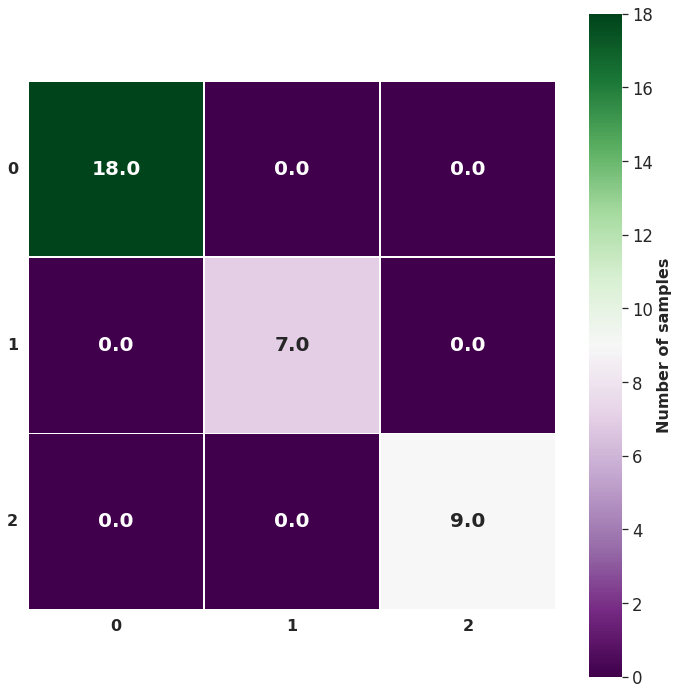

In [22]:
#show confusion matrix test set 
print('determining confusion matrix...')
   
confusion=confusion_matrix(y_test,model_test)
print(confusion)
    
plt.figure(figsize=(10,10))
#fig, ax = plt.subplots()
sns.set(font_scale=1.5)
ax=sns.heatmap(confusion,linewidths=.5,cmap="PRGn",square=True,annot=True, fmt=".1f",
               annot_kws={"size": 20,"style": "normal", "weight": "bold"},cbar_kws={'label': 'number of samples'})
ax.figure.axes[-1].set_ylabel('Number of samples', size=16, weight = 'bold')
plt.yticks(rotation="horizontal",fontsize = 16, weight = "bold")
plt.xticks(rotation="horizontal",fontsize = 16, weight = "bold")
plt.tight_layout()
plt.show() 

determining confusion matrix...
[[49  0  0]
 [ 0 39  0]
 [ 0  0 44]]


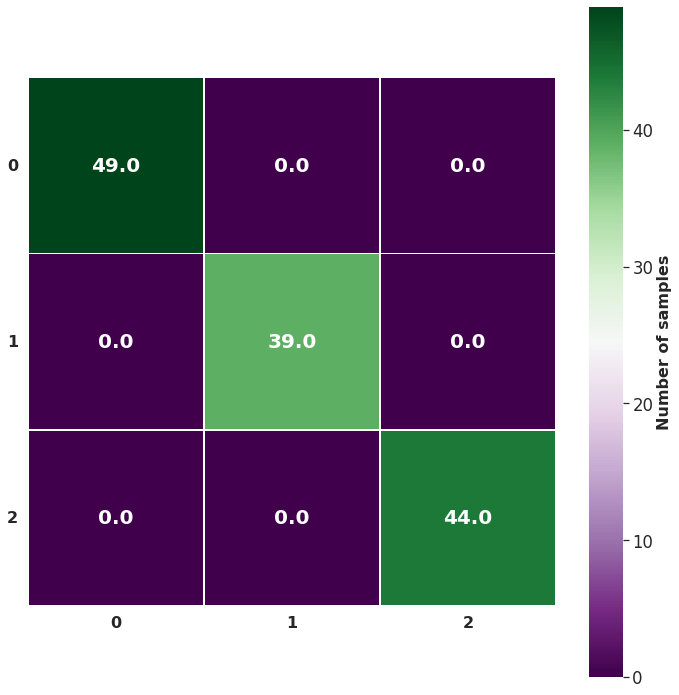

In [23]:
#show confusion matrix test set 
print('determining confusion matrix...')
   
confusion=confusion_matrix(y_train,model_train)
print(confusion)
    
plt.figure(figsize=(10,10))
#fig, ax = plt.subplots()
sns.set(font_scale=1.5)
ax=sns.heatmap(confusion,linewidths=.5,cmap="PRGn",square=True,annot=True, fmt=".1f",
               annot_kws={"size": 20,"style": "normal", "weight": "bold"},cbar_kws={'label': 'number of samples'})
ax.figure.axes[-1].set_ylabel('Number of samples', size=16, weight = 'bold')
plt.yticks(rotation="horizontal",fontsize = 16, weight = "bold")
plt.xticks(rotation="horizontal",fontsize = 16, weight = "bold")
plt.tight_layout()
plt.show() 

In [24]:
#print other classification metrics 
print(classification_report(y_test,model_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         9

    accuracy                           1.00        34
   macro avg       1.00      1.00      1.00        34
weighted avg       1.00      1.00      1.00        34



In [25]:
print(balanced_accuracy_score(y_test,model_test))

1.0


Feature Importance

In [26]:
X = X.drop(columns=["Index","Compound name"], axis=1)

In [27]:
#use best hyperparams and determine feature importance
params = dict(forest.best_params_)
forest_imp = ExtraTreesClassifier(**params)
forest_imp.fit(X,y)

importances = forest_imp.feature_importances_

In [28]:
std = np.std([tree.feature_importances_ for tree in forest_imp.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [29]:
#These are the top n most important features...
print("Feature ranking:")
features = X.columns 
ranked_features=[]
importances_feat = []
n_features = 20
for f in range(n_features):#X.shape[1]):
  ranked_features.append(features[indices[f]])
  importances_feat.append(importances[indices[f]])
  print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

Feature ranking:
1. CD_(3D) (0.171841)
2. CD_(2D) (0.137045)
3. Q_R- (0.120331)
4. Q_T (0.073512)
5. dis_x_A'2 (0.067912)
6. Q_AFE_(O) (0.059262)
7. |A'_dis| (0.057891)
8. |x_A'_dis| (0.045978)
9. Q_AFE_(A) (0.038714)
10. dis_y_A'1 (0.032292)
11. rot_angle (0.024591)
12. dis_y_A2 (0.021370)
13. dis_x_A1 (0.015721)
14. dis_x_A'1 (0.014672)
15. Total_mag_Outcar (0.012609)
16. |A_dis| (0.010727)
17. _cell_angle_gamma (0.010551)
18. Avg_BB' (0.008736)
19. _cell_length_b (0.008077)
20. |y_A'_dis| (0.008038)


In [30]:
intermediate_dictionary = {'Features':ranked_features, 'Importances':importances_feat}
# Convert dictionary to Pandas dataframe
feat_df = pd.DataFrame(intermediate_dictionary)

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ]),
 <a list of 9 Text major ticklabel objects>)

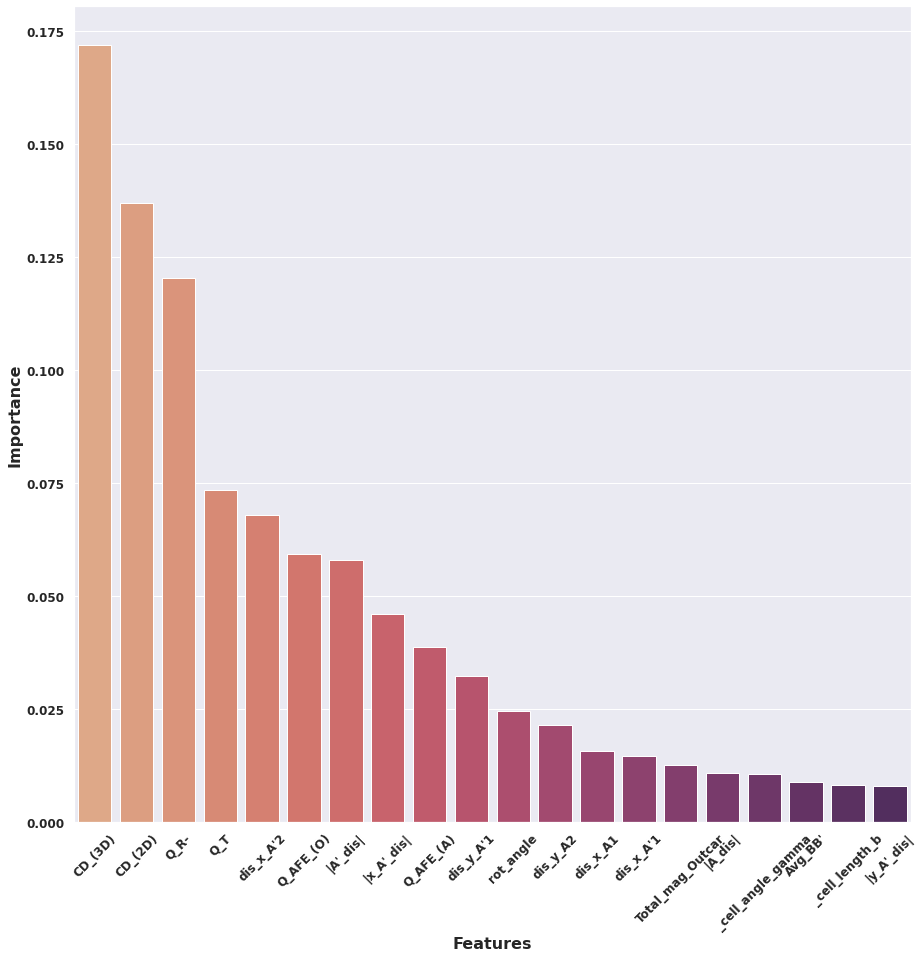

In [31]:
#plot feature importance scores
plt.figure(figsize=(15,15))
sns.barplot(x="Features", y="Importances", data=feat_df, palette="flare")
plt.xlabel('Features', fontdict={'fontsize' : 16, "weight" :"bold"})
plt.ylabel('Importance', fontdict={'fontsize' : 16, "weight" :"bold"})
plt.xticks(rotation=45, fontsize = 12, weight = "bold")
plt.yticks(fontsize = 12, weight = "bold")

Visualize Trees

In [32]:
params = dict(forest.best_params_)

In [33]:
model = ExtraTreesClassifier(**params)

In [34]:
model.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=True, max_depth=7, min_samples_leaf=2,
                     min_samples_split=15, n_estimators=15)

In [35]:
model.n_estimators

15

In [36]:
estimator = model.estimators_[6]

In [37]:
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns[:],
                class_names = str(model.classes_),
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [38]:
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [39]:
# Display output of Tree 7
Image(filename = 'tree.png')

Assigning Probabilistic Confidence Bounds

We only show this for the training set here. We have performed this analyses for the test set as well, as detailed in the referred manuscript.

For training data

In [40]:
#predict probabilities on training set 
model_train=forest.predict_proba(X_train)

In [41]:
#converting into dataframe
model_tr_np = np.zeros((model_train.shape[0]*model_train.shape[1],2))
for i in range(model_train.shape[0]):
  model_tr_np[i][0] = 0
  model_tr_np[i][1] = model_train[i][0]

  model_tr_np[i+model_train.shape[0]][0] = 1
  model_tr_np[i+model_train.shape[0]][1] = model_train[i][1]

  model_tr_np[i+2*model_train.shape[0]][0] = 2
  model_tr_np[i+2*model_train.shape[0]][1] = model_train[i][2]

In [42]:
dataframe_y_pred = pd.DataFrame(model_tr_np, columns=['Class','Mean Probability']) 

Text(0, 0.5, 'Mean Probability')

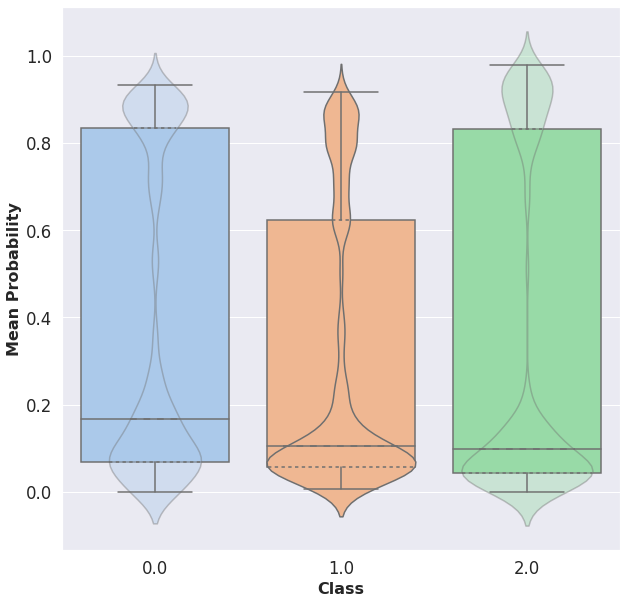

In [43]:
#plot probability distributions of each class
plt.figure(figsize=(10,10))
sns.violinplot(x="Class", y="Mean Probability", data=dataframe_y_pred, inner="quartile", palette='pastel',bw=.1)
ax = sns.boxplot(x="Class", y="Mean Probability", data=dataframe_y_pred, palette="pastel")
for box, alpha in zip(ax.collections[::2], [0.4,0.4,0.4]):
    box.set_alpha(alpha)
plt.xlabel('Class', fontdict={'fontsize' : 16, "weight" :"bold"})
plt.ylabel('Mean Probability', fontdict={'fontsize' : 16, "weight" :"bold"})

Make Interactive plots

In [44]:
prob_tr_df = pd.DataFrame(model_train, columns = ['Class_0','Class_1','Class_2'])
prob_tr_df['y_true'] = y_train.tolist()
indices_tr = X_train_z["Index"].tolist()

In [45]:
id_list = []
for i in indices_tr:
  id_list.append(int(i[5:]))
prob_tr_df['idx'] = id_list
comp_names_train = X_train_z["Compound name"]
comp_names_train = comp_names_train.to_frame()

In [46]:
prob_tr_df.reset_index(drop=True, inplace=True)
comp_names_train.reset_index(drop=True, inplace=True)
all_trains = pd.concat([comp_names_train,prob_tr_df],axis=1)

Shortlist candidates to perform DFT computations for compounds with predictions with high probability.
Here we consider the cut-off probability score to be 0.65 for each class.

In [47]:
Class_0_train = all_trains[all_trains['Class_0'] > 0.65]
Class_1_train = all_trains[all_trains['Class_1'] > 0.65]
Class_2_train = all_trains[all_trains['Class_2'] > 0.65]

In [50]:
print(Class_0_train)

    Compound name   Class_0   Class_1   Class_2  y_true  idx
0    SrSmMnNiO6_C  0.709585  0.230513  0.059901       0  157
6    HgSnMnNiO6_C  0.846502  0.063420  0.090078       0   45
8       RbYVWO6_C  0.931217  0.068783  0.000000       0  142
9     NaLuCoWO6_C  0.875219  0.090495  0.034286       0   84
10    NaYCoReO6_C  0.920458  0.059542  0.020000       0   95
15     NaLuVWO6_C  0.858413  0.107302  0.034286       0   90
19   LaGdMnNiO6_C  0.809728  0.111008  0.079264       0   66
20     RbYCrWO6_C  0.763099  0.162029  0.074872       0  128
25   GdSrMnNiO6_C  0.720672  0.239977  0.039352       0   38
31    NaYNiOsO6_C  0.831721  0.032239  0.136040       0  111
34     NaYCoWO6_C  0.896648  0.069066  0.034286       0   98
36   BaCeMnNiO6_C  0.898624  0.073228  0.028148       0    0
39      KYVReO6_C  0.895185  0.084815  0.020000       0   64
42   CdHfMnNiO6_C  0.914935  0.072944  0.012121       0   28
43   HgCeMnNiO6_C  0.705087  0.166956  0.127957       0   40
45   CaZrMnNiO6_C  0.881

Interactive Plots

In [51]:
fig = px.parallel_coordinates(prob_tr_df, color="y_true",
                             color_continuous_scale=px.colors.diverging.Tealrose)
fig.show()

Causal Analysis

Here, we show an example how to construct causal networks for classificaiton of Columnar and Layered. 
These analyses have been conducted for all other types of A-site ordering.

Columnar and Layered

In [52]:
#prepare dataframe based on the 10 most important features
X_causal = df.filter([feat_df['Features'][0],feat_df['Features'][1],feat_df['Features'][2],
                      feat_df['Features'][3],feat_df['Features'][4],feat_df['Features'][5],
                      feat_df['Features'][6],feat_df['Features'][7],feat_df['Features'][8],
                      feat_df['Features'][9],"target_label"],axis=1)

In [53]:
index_names = X_causal[ X_causal['target_label'] == 2].index

In [54]:
X_causal.drop(index_names, inplace = True)

In [55]:
np.random.seed(0)

In [56]:
#@title Utility function for causal network
#utility function
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

/usr/local/lib/python3.7/dist-packages/lingam/direct_lingam.py:206: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/lingam/direct_lingam.py:207: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/lingam/direct_lingam.py:137: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning:

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in m

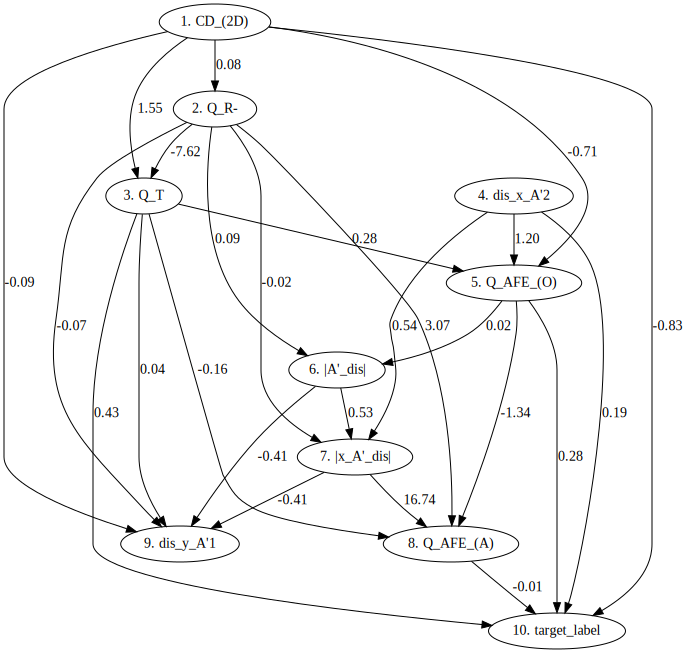

In [57]:
#create DirectLinGAM object
pk = make_prior_knowledge(
    n_variables=len(X_causal.columns),
    sink_variables=[10])

model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(X_causal)
labels = [f'{i}. {col}' for i, col in enumerate(X_causal.columns)]
make_graph(model.adjacency_matrix_, labels)